### Rebecq, H., Gallego, G., Mueggler, E., and Scaramuzza, D. (2017). EMVS: Event-Based Multi-View Stereo—3D Reconstruction with an Event Camera in Real-Time. International Journal of Computer Vision 1–21.

This notebook is an implementation of the above paper on semi-dense 3D reconstruction of a scene using back projection methods. The scene data is captured using an event camera. 

In [70]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import pyquaternion as qt
%matplotlib notebook
data_path = 'data/slider_depth'

### Scene Video

The DAVIS camera has a conventional image capturing system along with the event based system. While we shall not be using the conventional stream during our implementation, the conventional stream of data helps the user visualize the scene that is undergoing reconstruction.

In [5]:
normal_img_path = data_path + '/images'
normal_imgs = [normal_img_path + "/" + img for img in os.listdir(normal_img_path) if img.endswith(".png")]
normal_imgs.sort()

<IPython.core.display.Javascript object>


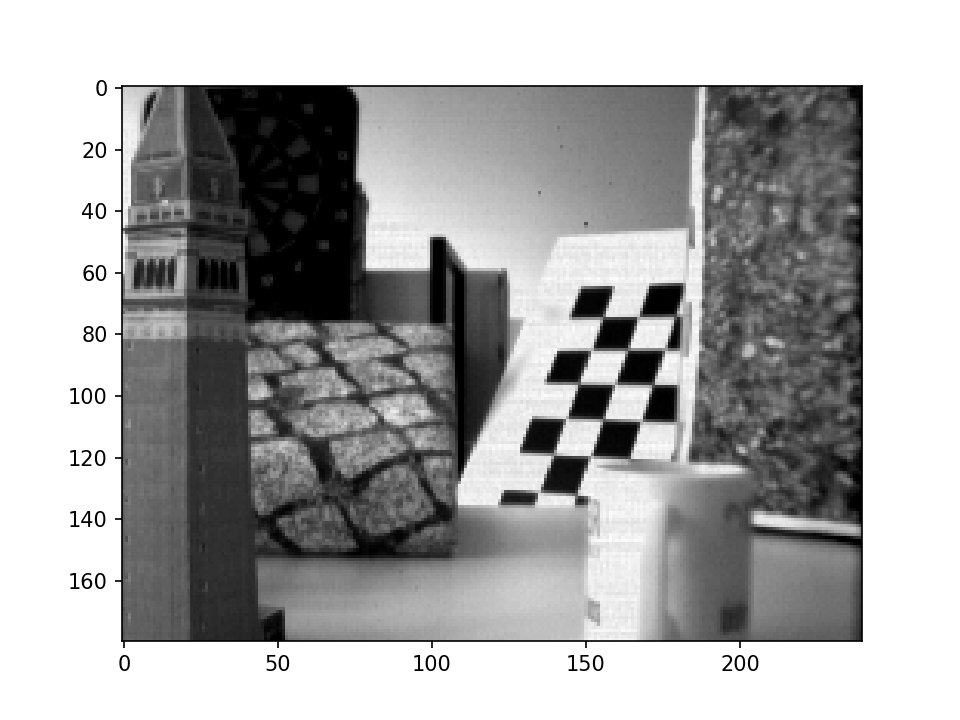

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
ax.axis()
for image in normal_imgs:
    ax.clear()
    ax.imshow(plt.imread(image), cmap='gray')
    fig.canvas.draw()

## Data Available and Data format

There are various kinds of data which we would have to work with namely, event data, imu data, calibration parameters, and ground truth data. There is also an 'images.txt' file which gives the timestamps at which synchronous event stream was captured. The format of the data are as shown below. 

![description of dataset format](data_format_emvs.png)

### Camera Matrix

Every camera has a calibration matrix which is dependant on the intrinsic and extrinsic parameters being used. We obtain these parameters from the <i>calib.txt</i> file.

In [8]:
def return_camera_matrix(filename='calib.txt'):
    '''
    Returns the camera matrix for the given dataset based on calibration parameters.
    
    Parameters:
    -----------
    filename : <string>
        name of the text file where the camera parameters are stored
    
    Return:
    -------
    camera_mat: <np.array>
        The camera matrix for the parameters mentioned in the calibration file
    '''
    
    file = open(data_path +'/' + filename, "r")
    cam_par = list(map(float,file.readline().split()))
    file.close()
    fx, fy, cx, cy, k1, k2, p1, p2, k3 = [par for par in cam_par]
    camera_mat = np.array([[fx,  0, cx],
                           [ 0, fy, cy],
                           [ 0,  0,  1]])
    return camera_mat, [k1, k2, p1, p2, k3]

In [9]:
def return_undistorted_coordinates(dist_cam_cords, distortion_params):
    k1, k2, p1, p2, k3 = distortion_params
    
    pass

In [10]:
cam_mat, dist_params = return_camera_matrix()

## Event, Pose tuple

The objective is to get an event and its corresponding pose for that particular time stamp. Since the number of events are huge and the homographies are expensive to compute, a batch of 256 events is assigned the same pose information. 

In [49]:
from itertools import islice
def return_event_batch(batch_number, filename='events.txt', batch_size = 256):
    events=[]
    file = open(data_path +'/' + filename, "r")
    head = list(islice(file, batch_number * batch_size, (batch_number + 1)*batch_size))
    #return timestamp of first event in the batch
    event_start_time = list(map(float,head[0].split()))[0] 
    for line in head:
        events.append(list(map(float,line.split())))
    file.close()
    return events, event_start_time

In [55]:
events, event_start_time = return_event_batch(batch_number=40)
print(event_start_time)

0.048514001


The pose is sampled at frequencies lower than the event data. In order to capture pose information for an event at some timestamp, it is thus necessary to linearly interpolate the pose data for that timestamp. As the trajectory is continuous and the sampling time is very small, we can assume the path between two timesteps to be fairly linear.

In [64]:
def get_ground_truth_pose(event_start_time, filename='groundtruth.txt'):
    ''' This function returns the the groundtruth pose for an event depending on the timestamp 
    of the input given as input to the function. If pose of the event is linearly interpolated 
    if the timestamp of the event given falls in between the timestamps of the poses of the two 
    events
    
    Parameters:
    -----------
    event_start_time : <float>
        timestamp of event for which pose information is to be estimated
    filename : <string>
        name of the file containing the groundtruth
        
    Return:
    -------
    pose : <list> of format [timestamp, px, py, pz, qx, qy, qz, qw]
        Returns a list describing the pose at the timestamp given by the event
    
    '''
    file = open(data_path +'/' + filename, "r")
    prev_pose = [0, 0, 0, 0, 0, 0, 0, 1]
    prev_time = prev_pose[0]  #start with initial time 0s 
    
    for line in file:
        current_pose = list(map(float,line.split()))
        current_time = current_pose[0]
        
        if event_start_time == current_time:
            return np.array(current_pose) #pose information for that time-step
        
        elif event_start_time > prev_time and event_start_time < current_time:
            print(current_pose)
            return linearly_interpolated_pose(current_pose, prev_pose, event_start_time) 
            
        elif event_start_time > current_time:
            prev_pose = current_pose
            prev_time = prev_pose[0]

In [65]:
def linearly_interpolated_pose(pose_t, pose_t_minus_1, time_bet):
    ''' Function to linearly interpolate the quaternion values for the timesteps provided
        
    '''
    # We will doing lerp on quaternions and linear intepolation on the translation vectors
    estimated_pose = []
    interpolater = time_bet /(pose_t[0] - pose_t_minus_1[0])
    
    interpolated_translation = interpolater *(np.array(pose_t[1:4]) - np.array(pose_t_minus_1[1:4]))
    
    
    pose_t_minus_1_qt = qt.Quaternion(pose_t_minus_1[7], pose_t_minus_1[4], pose_t_minus_1[5], pose_t_minus_1[6])
    pose_t_qt = qt.Quaternion(pose_t[7], pose_t[4], pose_t[5], pose_t[6])
    
    interpolated_rotation = qt.Quaternion.slerp(pose_t_minus_1_qt, pose_t_qt, interpolater)
    
    return estimated_pose

In [66]:
interpolated_pose = get_ground_truth_pose(event_start_time)

[0.051903182, 0.118854166667, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
linear interpolation is done for 0.048514001


<img src="quaternion_dt.png" alt="backprojection" style="width: 400px;"/>

<img src="slerp_quaternion.png" alt="backprojection" style="width: 200px;"/>

## Stages of Reconstruction

The algorithm for Event based Multi View Stereo proposed here uses five stages to do the reconstruction. It makes use of the Collins space sweep approach with a few changes. Projective sampling is used instead of uniform sampling. Also the thresholding is Adaptive Gaussian as opposed to Global thresholding used in Collins' algorithm.

### Stage 1: Backprojection

The 2-D points in the event stream are backprojected into a 3-D space. Since the event camera detects only edges, we can assume the rays corresponding to the same feature would intersect/ go very close to each in some unit volume.

<img src="backprojection.png" alt="backprojection" style="width: 400px;"/>


### Stage 2: Volumetric Ray Counting

We assume our backprojected rays from different views to pass through some 3-D Volume divided into voxels. A scoring function is associated with each voxel. The score of each voxel is determined by the number of rays passing through it. It is given as shown below. <b>X</b> is the co-ordinate of the centre of a voxel.

<img src="scoring.png" alt="scoring" style="width: 200px;"/>

### Stage 3: Voting

Local maxima of <b>f(X)</b> is determined here. It is done by by using adaptive gaussian thresholding on the confidence map c(x,y). After this procedure a scene structure should have been formed.

In [9]:
def adaptive_gaussian_thresholding():
    pass

### Stage 4: Scene Merging

This is used to merge scenes obtained while the camera is moving. The key reference view is changed when the distance moved by the camera w.r.t to the reference view exceeds some percentage of the mean scene depth (15 to 40%)

### Stage 5: Cleaning

The edges obtained are cleaned using median filters and radius filters

In [15]:
def radius_filter():
    pass

In [18]:
def median_filter():
    pass

## The Algorithm

The algorithm given by Rebecq et al. is as shown below. Note that there are some guidelines given by Rebecq et al. to speed up computations which must be followed.

<img src="algorithm.png" alt="The Algorithm" style="width: 400px;" align='left'/>

In [10]:
def bundle_events():
    '''Homography matrices are expensive to compute. 
       Make batches of n-events so that they can share the same Homography matrix.
       '''
    pass

In [13]:
Z = 100 #number of depth planes
